# Matrix Factorization using Gradient Descent

In this excercise, you are required to implement matrix factorization method, specifically [Non-Negative Matrix Factorization (NMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization), using gradient descent. You have to apply the matrix factorization to solve topic modeling. 

(Please refer to the tutorial on basics of topic modeling, LSI with SVD (Tutorial Set 4), for details on LSI)

## Applying NMF to solve Topic Modeling
Given a term document matrix $V$, NMF factorizes it into two matrix $W$ and $H$ with the property that all three documents have no negative elements.
<img src="content/NMF.png" alt="Non-negative matrix factorization" style="width: 80%">

In Non-negative Matrix Factorization, a document-term matrix is approximately factorized into term-feature and feature-document matrices.

$V = WH$ Matrix multiplication can be implemented as computing the column vectors of $V$ as linear combinations of the basis vectors (column vectors) in $W$ (or the topics discovered from the documents) using coefficients supplied by columns of $H$ (or the membership weights for the topics in each document). That is, each column of V can be computed as follows:
$$ v_i = W h_i$$

In what follows, we will first see an example of applying NMF by using [SKLearn NMF API](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) for the task of topic modeling. Later you will be required to implement NMF using gradient descent.

### Scikit-Learn implementation of NMF for topic modeling
Given a set of multivariate  $n$-dimensional data vectors, they are put into an  $n\times m$  matrix  $V$  as its columns, where  $m$  is the number of examples in the data set. This matrix  $V$  is approximately factorized into an  $n \times t$  matrix  $W$  and an  $t \times m$  matrix  $H$ , where  $t$  is generally less than  $n$  or  $m$ . Hence, this results in a compression of the original data matrix.

In terms of topic modeling, the input document-term matrix  $V$  is factorized into a  $n \times t$  document-topic matrix and a  $t \times m$  topic-term matrix, where  $t$  is the number of topics produced. Similar to tutorial 4, we will be using 20 NewsFetch dataset for the task.

#### Imports

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

#### Setup data

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

#### Compute document features

In [3]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors_tfidf.shape

(2034, 26576)

#### Compute NMF using Scikit Learn library

We will also write a function to display top 8 words for each topic.

In [4]:
num_top_words=8
vocab = np.array(vectorizer_tfidf.get_feature_names())

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [5]:
from sklearn import decomposition

d = 5 # num topics
clf = decomposition.NMF(n_components=d, random_state=1)

In [6]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [7]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

# Excercise

## NMF using SGD

In stochastic gradient descent (SGD), we evaluate our loss function on just a sample of our data (sometimes called a mini-batch). We would get different loss values on different samples of the data, so this is why it is stochastic. It turns out that this is still an effective way to optimize, and it's much more efficient!

### Applying SGD to NMF

Goal: Decompose $V\;(m \times n)$ into
$$ V \approx HW$$
where $W\;(m \times d)$ and $H\;(d \times n)$, $W,\;H\; \geq \;0$, and we've minimized the Frobenius norm of $V-WH$. The objective function can therefore be written as the following:
$$
\min_{H \geq 0, W \geq 0} F(H,W) = \frac{1}{2} ||V - HW||^{2} + \frac{\lambda}{2} \left( ||H||^2 + ||W||^2 \right)
$$

### Implementation of NMF using SGD (Excercise)
__Approach:__ Given the objective function above, pick random positive $W$ & $H$, and then use SGD to optimize. 

(Note that the objective function is non-convex in nature, and is convex only if we consider $H$ and $W$ separately. You can directly write the gradient descent rule for the objective function presented above)



In [8]:
def grads(V, W, H, lam):
    R = W@H - V
    grad_W = np.dot(R, H.T) + lam*2*W
    grad_H = np.dot(W.T, R) + lam*2*H
    return grad_W, grad_H

In [9]:
def get_loss(V, W, H, lam):
    R = V - W@H
    loss = (1/2)*np.linalg.norm(R)**2 + (lam/2)*(np.linalg.norm(H)**2 + np.linalg.norm(W)**2)
    return loss

In [18]:
''' WRITE YOUR CODE BELOW '''
m, n = vectors_tfidf.shape
W_train = np.abs(np.random.normal(scale=0.01, size=(m, d)))
H_train = np.abs(np.random.normal(scale=0.01, size=(d, n)))
V = vectors_tfidf
lr = 3e-2
epochs = 50
losses = []
lam = 1e-3
steps = 10
for e in tqdm(range(1, epochs+1)):
    loss = get_loss(V, W_train, H_train, lam)
    losses.append(loss)
    grad_W, grad_H = grads(V, W_train, H_train, lam)
    W_train -= lr*grad_W
    H_train -= lr*grad_H
    if e%steps == 0:
        tqdm.write(f"Epoch: {e}")
        tqdm.write(f"Loss: {loss}")

Epoch: 10
Loss: 982.7353418146357
Epoch: 20
Loss: 978.0722453828744
Epoch: 30
Loss: 974.694030795468
Epoch: 40
Loss: 973.0669732365885
Epoch: 50
Loss: 971.2870729908288



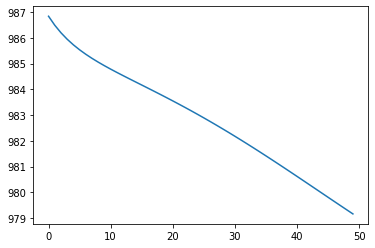

In [15]:
plt.plot(losses)

In [16]:
get_loss(V, W1, H1, lam)

955.4272470343128

In [17]:
show_topics(H_train)

['god space people don think like just know',
 'space don god know like people just think',
 'don people space just god think like know',
 'just don people space god like think know',
 'god space just people don think like know']